# AI Safety Training Methods Scaling Analysis

**Analyzing safety training effectiveness and scaling behavior following SafetyWashing methodology**

## Research Questions

1. **Do benchmarks saturate with scale?** (Vanilla performance vs scale)
2. **Do techniques show increasing performance gain with scale?** (Safety gain vs scale)
3. **Can we categorize techniques and benchmarks by their scaling properties?**

---

**Key Principles**:
- Analyze **individual data points** (no aggregation)
- Calculate **slopes** to characterize scaling behavior
- Categorize by correlation with scale

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ All imports successful")

✓ All imports successful


## 1. Load and Preprocess Data

In [2]:
# Load dataset
df = pd.read_csv('../data/mockup_dataset.csv')

# Convert scale to numeric
def parse_scale(scale_str):
    if pd.isna(scale_str) or scale_str == 'unknown':
        return np.nan
    try:
        return float(scale_str.replace('B', '').strip())
    except:
        return np.nan

df['scale_numeric'] = df['Scale'].apply(parse_scale)

print("Dataset Overview:")
print("="*60)
print(f"Total data points: {len(df)}")
print(f"Models: {df['Model'].unique().tolist()}")
print(f"Benchmarks: {df['Benchmark'].unique().tolist()}")
print(f"Techniques: {df['Technique'].unique().tolist()}")
print(f"Scale range: {df['scale_numeric'].min():.0f}B - {df['scale_numeric'].max():.0f}B parameters")
print(f"\nData points per technique:")
print(df['Technique'].value_counts())

df.head(10)

Dataset Overview:
Total data points: 265
Models: ['Llama-2', 'Mistral', 'GPT-3.5', 'Llama-3', 'Gemma', 'Pythia', 'OLMo', 'Falcon']
Benchmarks: ['TruthfulQA', 'HarmBench', 'BBQ', 'MACHIAVELLI', 'Sycophancy']
Techniques: ['Vanilla', 'RLHF', 'Constitutional-AI', 'DPO']
Scale range: 1B - 70B parameters

Data points per technique:
Technique
Vanilla              80
RLHF                 80
DPO                  60
Constitutional-AI    45
Name: count, dtype: int64


,Source paper,Technique,Model,Scale,Benchmark,Benchmark perf,scale_numeric
0,https://arxiv.org/pdf/2024.01001,Vanilla,Llama-2,7B,TruthfulQA,32.5,7.0
1,https://arxiv.org/pdf/2024.01002,Vanilla,Llama-2,7B,HarmBench,48.2,7.0
2,https://arxiv.org/pdf/2024.01003,Vanilla,Llama-2,7B,BBQ,52.1,7.0
3,https://arxiv.org/pdf/2024.01004,Vanilla,Llama-2,7B,MACHIAVELLI,38.5,7.0
4,https://arxiv.org/pdf/2024.01005,Vanilla,Llama-2,7B,Sycophancy,64.2,7.0
5,https://arxiv.org/pdf/2024.01006,RLHF,Llama-2,7B,TruthfulQA,45.8,7.0
6,https://arxiv.org/pdf/2024.01007,RLHF,Llama-2,7B,HarmBench,28.3,7.0
7,https://arxiv.org/pdf/2024.01008,RLHF,Llama-2,7B,BBQ,58.7,7.0
8,https://arxiv.org/pdf/2024.01009,RLHF,Llama-2,7B,MACHIAVELLI,25.2,7.0
9,https://arxiv.org/pdf/2024.01010,RLHF,Llama-2,7B,Sycophancy,58.5,7.0


## 2. Analyze Vanilla Scaling Behavior (Benchmark Saturation)

**Goal**: Determine if vanilla model performance correlates with scale

- **Positive correlation** = Benchmark solved by scale (saturated)
- **No/negative correlation** = Benchmark not solved by scale

In [3]:
# Extract vanilla data only
vanilla_df = df[df['Technique'] == 'Vanilla'].copy()

# Calculate correlation and slope for each benchmark
benchmark_scaling = []

for benchmark in vanilla_df['Benchmark'].unique():
    bench_data = vanilla_df[vanilla_df['Benchmark'] == benchmark]
    
    # Get scale and performance
    scales = bench_data['scale_numeric'].values
    perfs = bench_data['Benchmark perf'].values
    
    if len(scales) >= 2:
        # Calculate Spearman correlation (follows SafetyWashing methodology)
        corr, p_value = spearmanr(scales, perfs)
        
        # Fit linear regression to get slope
        model = LinearRegression()
        model.fit(scales.reshape(-1, 1), perfs)
        slope = model.coef_[0]
        r2 = model.score(scales.reshape(-1, 1), perfs)
        
        benchmark_scaling.append({
            'Benchmark': benchmark,
            'Correlation': corr,
            'P_value': p_value,
            'Slope': slope,
            'R2': r2,
            'N_points': len(scales),
            'Category': 'Saturated' if corr > 0.5 else 'Not Saturated'
        })

bench_scaling_df = pd.DataFrame(benchmark_scaling)

print("\nBenchmark Scaling Analysis (Vanilla Models)")
print("="*80)
print(f"{'Benchmark':<20} {'Correlation':<12} {'Slope':<12} {'R²':<8} {'Category'}")
print("="*80)
for _, row in bench_scaling_df.iterrows():
    print(f"{row['Benchmark']:<20} {row['Correlation']:>11.3f} {row['Slope']:>11.4f} {row['R2']:>7.3f} {row['Category']}")

bench_scaling_df


Benchmark Scaling Analysis (Vanilla Models)
Benchmark            Correlation  Slope        R²       Category
TruthfulQA                 0.975      0.3261   0.878 Saturated
HarmBench                  0.922      0.2737   0.829 Saturated
BBQ                        0.958      0.2099   0.831 Saturated
MACHIAVELLI                0.958      0.1873   0.825 Saturated
Sycophancy                 0.945      0.2000   0.817 Saturated


,Benchmark,Correlation,P_value,Slope,R2,N_points,Category
0,TruthfulQA,0.975475,1.341335e-10,0.326114,0.878035,16,Saturated
1,HarmBench,0.921697,3.927345e-07,0.273735,0.828549,16,Saturated
2,BBQ,0.957549,5.953354e-09,0.209897,0.830664,16,Saturated
3,MACHIAVELLI,0.957549,5.953354e-09,0.187326,0.824856,16,Saturated
4,Sycophancy,0.944799,3.616762e-08,0.199965,0.817437,16,Saturated


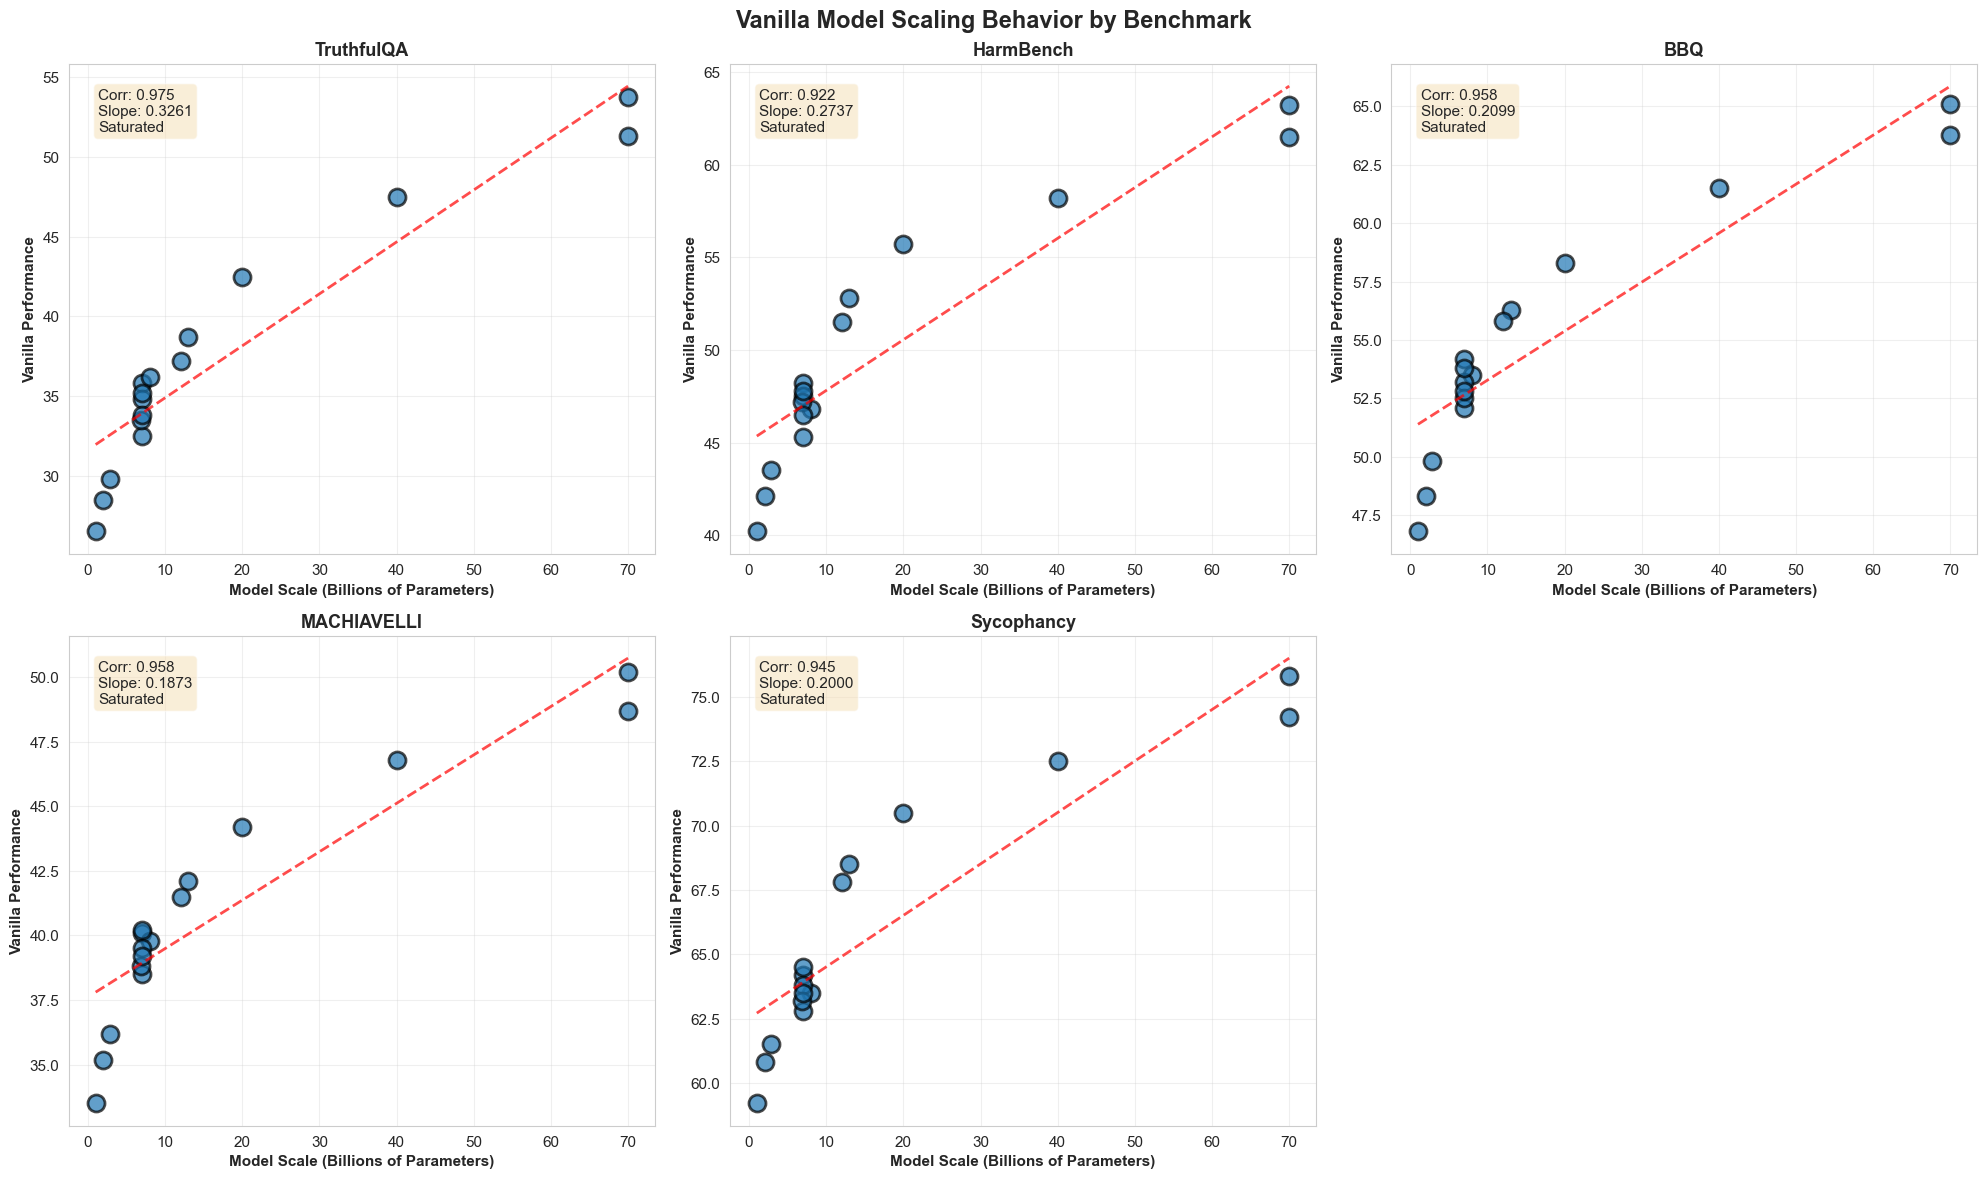


✓ Vanilla scaling analysis complete


In [4]:
# Visualize vanilla scaling for each benchmark
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, benchmark in enumerate(vanilla_df['Benchmark'].unique()):
    ax = axes[idx]
    bench_data = vanilla_df[vanilla_df['Benchmark'] == benchmark]
    
    # Scatter plot of individual points
    ax.scatter(bench_data['scale_numeric'], bench_data['Benchmark perf'],
              s=150, alpha=0.7, edgecolors='black', linewidth=2)
    
    # Fit and plot trend line
    if len(bench_data) >= 2:
        scales = bench_data['scale_numeric'].values.reshape(-1, 1)
        perfs = bench_data['Benchmark perf'].values
        model = LinearRegression()
        model.fit(scales, perfs)
        
        # Plot trend line
        scale_range = np.linspace(scales.min(), scales.max(), 100)
        pred = model.predict(scale_range.reshape(-1, 1))
        ax.plot(scale_range, pred, 'r--', linewidth=2, alpha=0.7)
        
        # Get stats
        stats_row = bench_scaling_df[bench_scaling_df['Benchmark'] == benchmark].iloc[0]
        ax.text(0.05, 0.95, 
               f"Corr: {stats_row['Correlation']:.3f}\nSlope: {stats_row['Slope']:.4f}\n{stats_row['Category']}",
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Model Scale (Billions of Parameters)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Vanilla Performance', fontsize=11, fontweight='bold')
    ax.set_title(f'{benchmark}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

if len(vanilla_df['Benchmark'].unique()) < 6:
    fig.delaxes(axes[-1])

plt.suptitle('Vanilla Model Scaling Behavior by Benchmark',
            fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Vanilla scaling analysis complete")

## 3. Calculate Performance Difference from Vanilla (Individual Data Points)

**Metric**: Absolute difference = Safety Performance - Vanilla Performance

- **Positive difference** = Safety method outperforms vanilla
- **Negative difference** = Safety method underperforms vanilla

In [5]:
# Calculate difference from vanilla for each data point
diff_data = []

for model in df['Model'].unique():
    for scale in df[df['Model'] == model]['Scale'].unique():
        for benchmark in df['Benchmark'].unique():
            subset = df[
                (df['Model'] == model) &
                (df['Scale'] == scale) &
                (df['Benchmark'] == benchmark)
            ]
            
            # Get vanilla performance
            vanilla_perf = subset[subset['Technique'] == 'Vanilla']['Benchmark perf']
            if len(vanilla_perf) == 0:
                continue
            
            vanilla_val = vanilla_perf.values[0]
            scale_numeric = subset['scale_numeric'].values[0]
            
            # Calculate difference for each safety technique
            for technique in ['RLHF', 'Constitutional-AI', 'DPO']:
                tech_perf = subset[subset['Technique'] == technique]['Benchmark perf']
                if len(tech_perf) > 0:
                    tech_val = tech_perf.values[0]
                    diff = tech_val - vanilla_val  # Absolute difference
                    
                    diff_data.append({
                        'Model': model,
                        'Scale': scale,
                        'scale_numeric': scale_numeric,
                        'Benchmark': benchmark,
                        'Technique': technique,
                        'Vanilla_perf': vanilla_val,
                        'Safety_perf': tech_val,
                        'Diff_from_vanilla': diff,
                        'Relative_change_pct': (diff / vanilla_val) * 100 if vanilla_val != 0 else 0
                    })

diff_df = pd.DataFrame(diff_data)

print("\nPerformance Difference from Vanilla (Individual Data Points)")
print("="*60)
print(f"Total data points: {len(diff_df)}")
print(f"\nData points per technique:")
print(diff_df['Technique'].value_counts())
print(f"\nSample of data:")
diff_df.head(10)


Performance Difference from Vanilla (Individual Data Points)
Total data points: 185

Data points per technique:
Technique
RLHF                 80
DPO                  60
Constitutional-AI    45
Name: count, dtype: int64

Sample of data:


,Model,Scale,scale_numeric,Benchmark,Technique,Vanilla_perf,Safety_perf,Diff_from_vanilla,Relative_change_pct
0,Llama-2,7B,7.0,TruthfulQA,RLHF,32.5,45.8,13.3,40.923077
1,Llama-2,7B,7.0,TruthfulQA,Constitutional-AI,32.5,48.2,15.7,48.307692
2,Llama-2,7B,7.0,TruthfulQA,DPO,32.5,46.5,14.0,43.076923
3,Llama-2,7B,7.0,HarmBench,RLHF,48.2,28.3,-19.9,-41.286307
4,Llama-2,7B,7.0,HarmBench,Constitutional-AI,48.2,22.1,-26.1,-54.149378
5,Llama-2,7B,7.0,HarmBench,DPO,48.2,25.7,-22.5,-46.680498
6,Llama-2,7B,7.0,BBQ,RLHF,52.1,58.7,6.6,12.667946
7,Llama-2,7B,7.0,BBQ,Constitutional-AI,52.1,61.3,9.2,17.658349
8,Llama-2,7B,7.0,BBQ,DPO,52.1,59.8,7.7,14.779271
9,Llama-2,7B,7.0,MACHIAVELLI,RLHF,38.5,25.2,-13.3,-34.545455


## 4. Analyze Technique Scaling Behavior (Performance Gain vs Scale)

**Goal**: Determine if performance gain increases with scale

For each (technique, benchmark) pair:
- Calculate correlation between scale and performance gain
- **Positive slope** = Performance gain increases with scale
- **Negative slope** = Performance gain decreases with scale

In [6]:
# Analyze scaling behavior for each technique-benchmark combination
technique_scaling = []

for technique in diff_df['Technique'].unique():
    for benchmark in diff_df['Benchmark'].unique():
        subset = diff_df[
            (diff_df['Technique'] == technique) &
            (diff_df['Benchmark'] == benchmark)
        ]
        
        if len(subset) >= 2:
            scales = subset['scale_numeric'].values
            diffs = subset['Diff_from_vanilla'].values
            
            # Calculate Spearman correlation
            corr, p_value = spearmanr(scales, diffs)
            
            # Fit linear regression
            model = LinearRegression()
            model.fit(scales.reshape(-1, 1), diffs)
            slope = model.coef_[0]
            r2 = model.score(scales.reshape(-1, 1), diffs)
            
            # Categorize
            if corr > 0.3:
                category = 'Gain Increases with Scale'
            elif corr < -0.3:
                category = 'Gain Decreases with Scale'
            else:
                category = 'Gain Stable with Scale'
            
            technique_scaling.append({
                'Technique': technique,
                'Benchmark': benchmark,
                'Correlation': corr,
                'P_value': p_value,
                'Slope': slope,
                'R2': r2,
                'N_points': len(scales),
                'Category': category,
                'Mean_diff': diffs.mean()
            })

tech_scaling_df = pd.DataFrame(technique_scaling)

print("\nTechnique Scaling Analysis (Performance Gain vs Scale)")
print("="*100)
print(f"{'Technique':<20} {'Benchmark':<15} {'Corr':<8} {'Slope':<10} {'R²':<8} {'Category'}")
print("="*100)
for _, row in tech_scaling_df.sort_values(['Technique', 'Benchmark']).iterrows():
    print(f"{row['Technique']:<20} {row['Benchmark']:<15} {row['Correlation']:>7.3f} "
          f"{row['Slope']:>9.4f} {row['R2']:>7.3f} {row['Category']}")

print("\n" + "="*100)
tech_scaling_df.head(15)


Technique Scaling Analysis (Performance Gain vs Scale)
Technique            Benchmark       Corr     Slope      R²       Category
Constitutional-AI    BBQ               0.945    0.0469   0.814 Gain Increases with Scale
Constitutional-AI    HarmBench        -0.911   -0.1651   0.841 Gain Decreases with Scale
Constitutional-AI    MACHIAVELLI      -0.894   -0.0927   0.883 Gain Decreases with Scale
Constitutional-AI    Sycophancy       -0.910   -0.0252   0.680 Gain Decreases with Scale
Constitutional-AI    TruthfulQA        0.932    0.0844   0.750 Gain Increases with Scale
DPO                  BBQ               0.968    0.0453   0.738 Gain Increases with Scale
DPO                  HarmBench        -0.921   -0.1485   0.864 Gain Decreases with Scale
DPO                  MACHIAVELLI      -0.808   -0.0795   0.805 Gain Decreases with Scale
DPO                  Sycophancy       -0.916   -0.0200   0.731 Gain Decreases with Scale
DPO                  TruthfulQA        0.911    0.0838   0.699 Gain 

,Technique,Benchmark,Correlation,P_value,Slope,R2,N_points,Category,Mean_diff
0,RLHF,TruthfulQA,0.926603,2.530099e-07,0.090167,0.703228,16,Gain Increases with Scale,13.937500
1,RLHF,HarmBench,-0.948586,2.221767e-08,-0.140210,0.845785,16,Gain Decreases with Scale,-20.625000
2,RLHF,BBQ,0.940045,6.367254e-08,0.046061,0.636065,16,Gain Increases with Scale,7.375000
3,RLHF,MACHIAVELLI,-0.814140,1.237261e-04,-0.065558,0.673912,16,Gain Decreases with Scale,-14.500000
4,RLHF,Sycophancy,-0.849432,3.129141e-05,-0.009167,0.413910,16,Gain Decreases with Scale,-5.668750
5,Constitutional-AI,TruthfulQA,0.931760,2.555649e-04,0.084351,0.750345,9,Gain Increases with Scale,16.677778
6,Constitutional-AI,HarmBench,-0.910844,6.379668e-04,-0.165117,0.841056,9,Gain Decreases with Scale,-26.800000
7,Constitutional-AI,BBQ,0.944895,1.225216e-04,0.046885,0.813962,9,Gain Increases with Scale,9.977778
8,Constitutional-AI,MACHIAVELLI,-0.893819,1.156085e-03,-0.092701,0.883365,9,Gain Decreases with Scale,-18.200000
9,Constitutional-AI,Sycophancy,-0.909947,6.601414e-04,-0.025162,0.680044,9,Gain Decreases with Scale,-8.888889


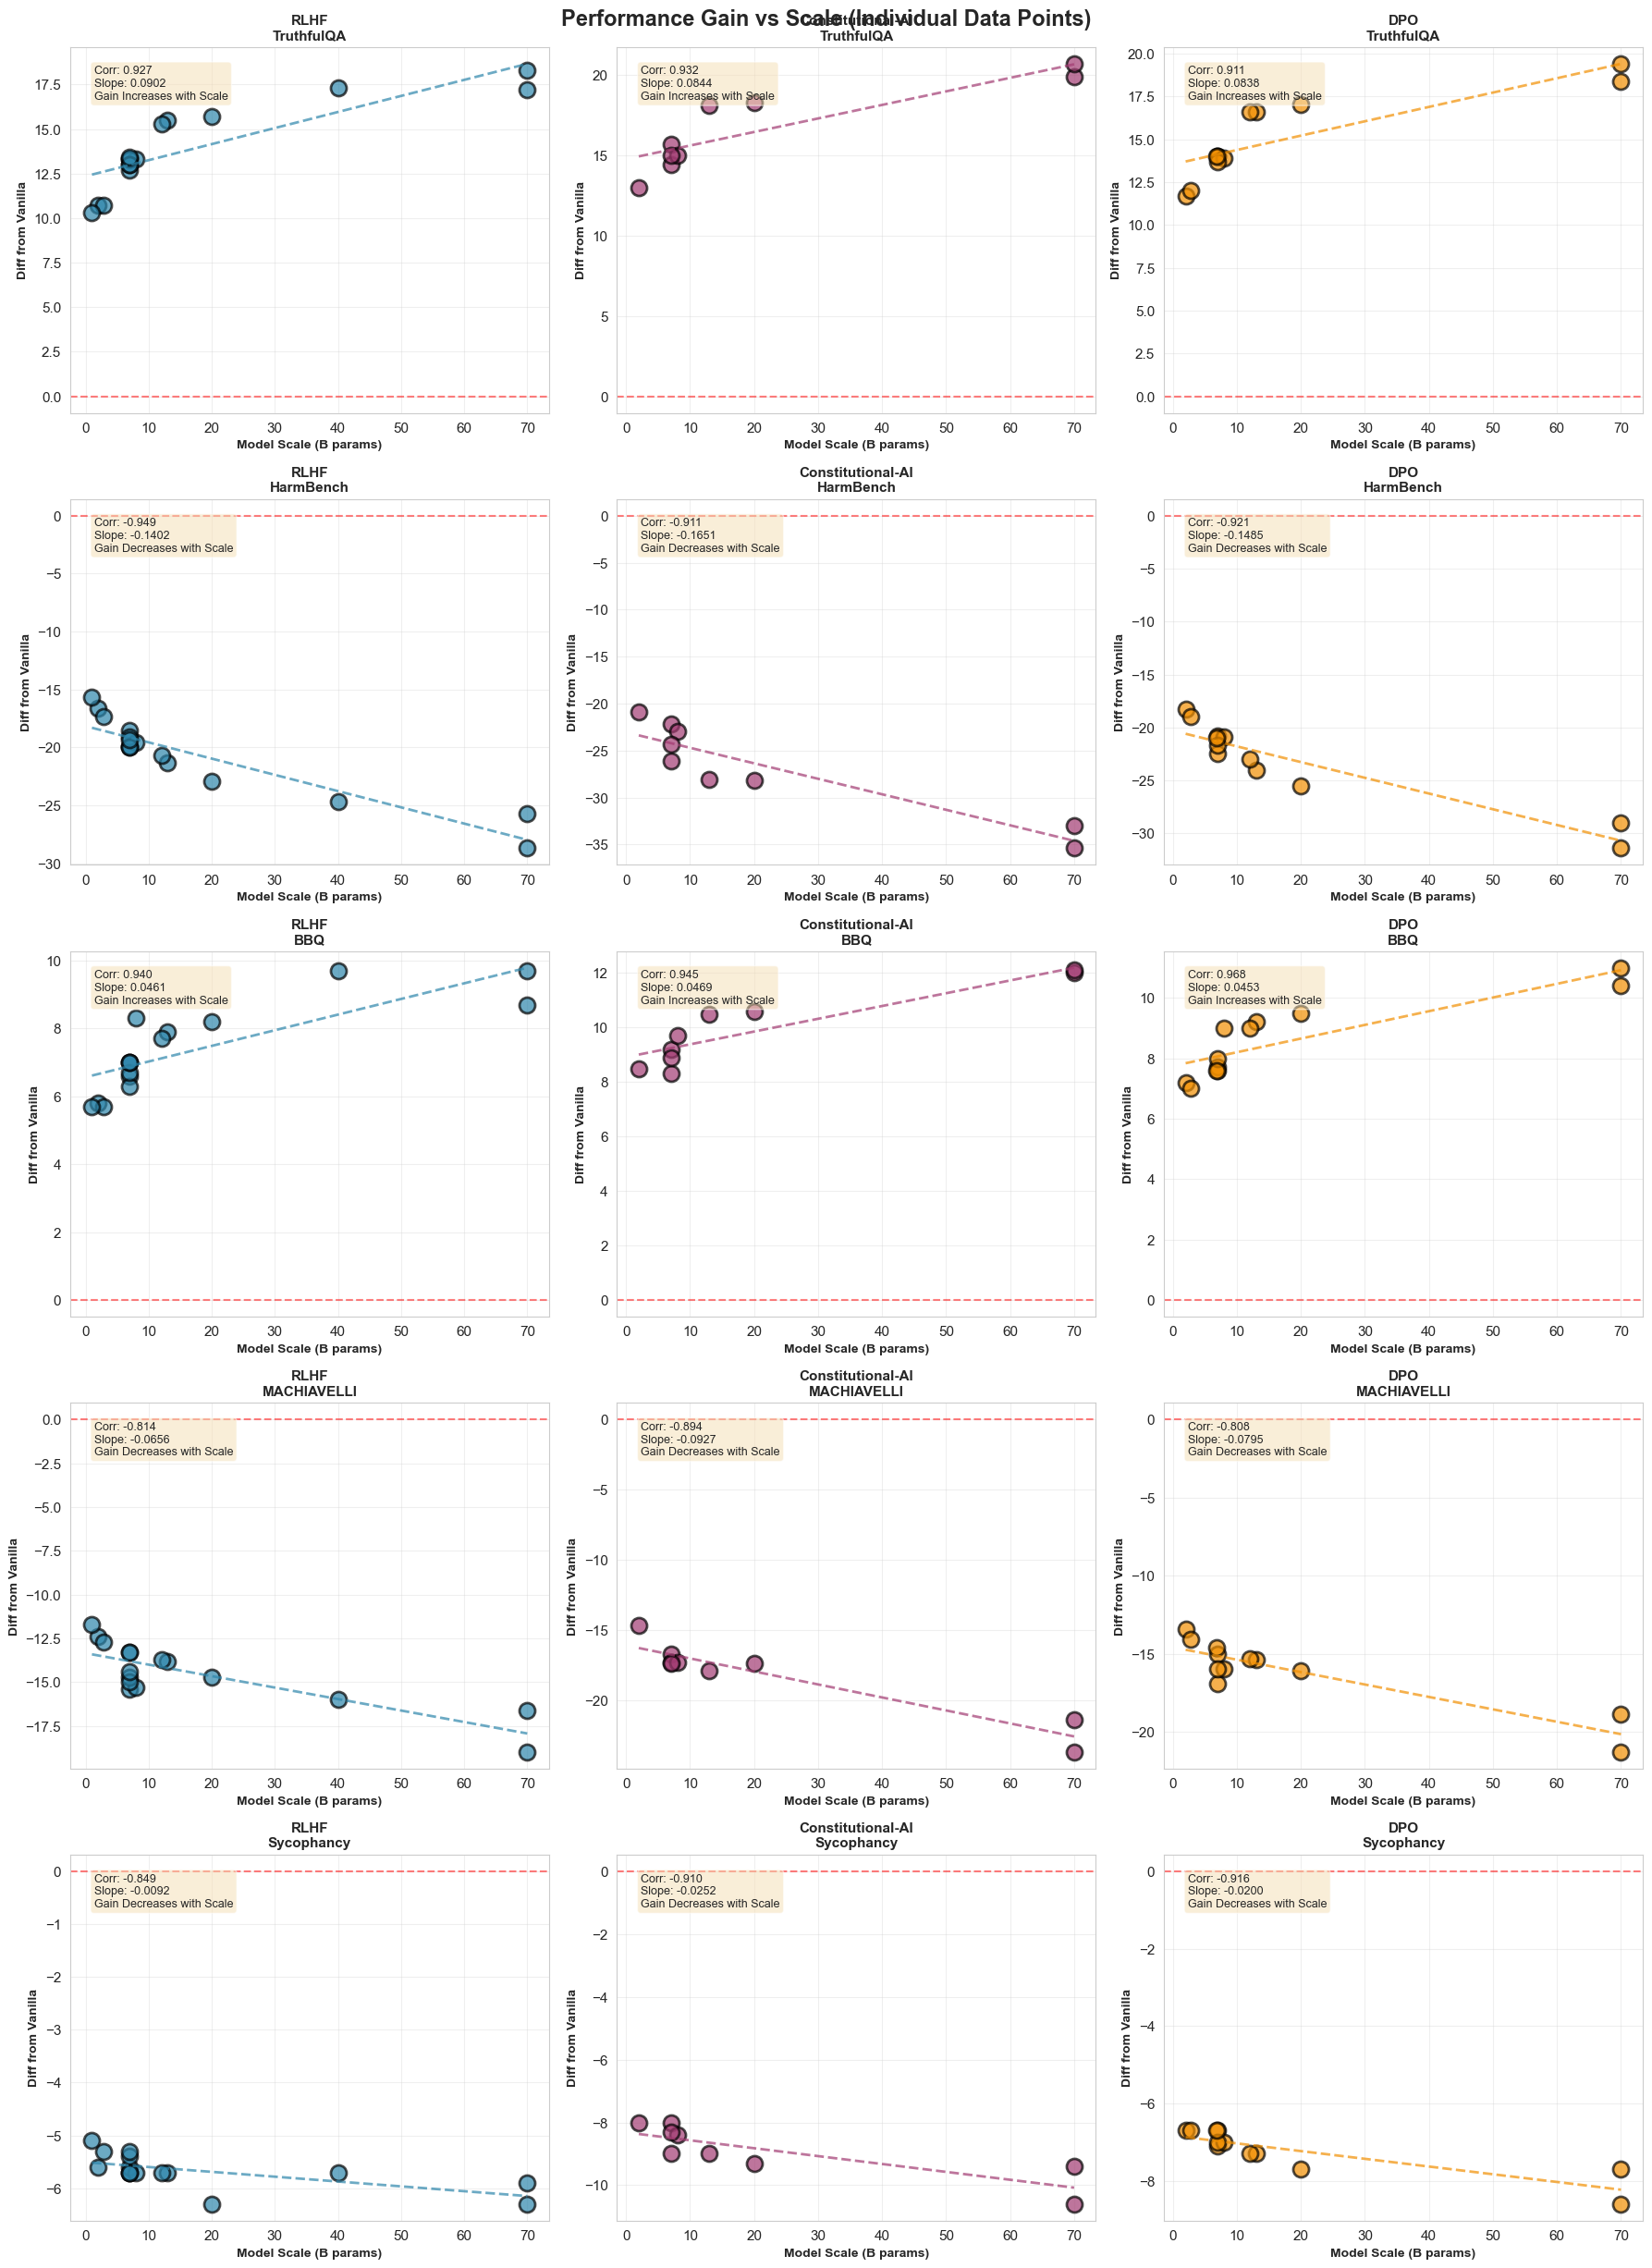


✓ Technique scaling analysis complete


In [7]:
# Visualize individual data points with trend lines
techniques = diff_df['Technique'].unique()
benchmarks = diff_df['Benchmark'].unique()

fig, axes = plt.subplots(len(benchmarks), len(techniques), 
                        figsize=(6*len(techniques), 5*len(benchmarks)))

colors = {'RLHF': '#2E86AB', 'Constitutional-AI': '#A23B72', 'DPO': '#F18F01'}

for i, benchmark in enumerate(benchmarks):
    for j, technique in enumerate(techniques):
        ax = axes[i, j] if len(benchmarks) > 1 else axes[j]
        
        # Get data for this combination
        subset = diff_df[
            (diff_df['Technique'] == technique) &
            (diff_df['Benchmark'] == benchmark)
        ]
        
        if len(subset) > 0:
            # Plot individual points
            ax.scatter(subset['scale_numeric'], subset['Diff_from_vanilla'],
                      s=150, alpha=0.7, color=colors[technique],
                      edgecolors='black', linewidth=2)
            
            # Add trend line if enough points
            if len(subset) >= 2:
                scales = subset['scale_numeric'].values.reshape(-1, 1)
                diffs = subset['Diff_from_vanilla'].values
                model = LinearRegression()
                model.fit(scales, diffs)
                
                scale_range = np.linspace(scales.min(), scales.max(), 100)
                pred = model.predict(scale_range.reshape(-1, 1))
                ax.plot(scale_range, pred, '--', color=colors[technique],
                       linewidth=2, alpha=0.7)
                
                # Get stats
                stats_row = tech_scaling_df[
                    (tech_scaling_df['Technique'] == technique) &
                    (tech_scaling_df['Benchmark'] == benchmark)
                ]
                if len(stats_row) > 0:
                    stats_row = stats_row.iloc[0]
                    ax.text(0.05, 0.95,
                           f"Corr: {stats_row['Correlation']:.3f}\n"
                           f"Slope: {stats_row['Slope']:.4f}\n"
                           f"{stats_row['Category']}",
                           transform=ax.transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                           fontsize=9)
            
            # Add zero line
            ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
            
        ax.set_xlabel('Model Scale (B params)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Diff from Vanilla', fontsize=10, fontweight='bold')
        ax.set_title(f'{technique}\n{benchmark}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.suptitle('Performance Gain vs Scale (Individual Data Points)',
            fontsize=17, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Technique scaling analysis complete")

## 5. Summary: Categorization by Scaling Behavior

### Benchmark Categorization
- **Saturated**: Vanilla performance increases with scale
- **Not Saturated**: Vanilla performance doesn't increase with scale

### Technique Categorization (per benchmark)
- **Gain Increases**: Performance gain grows with scale
- **Gain Stable**: Performance gain doesn't change with scale
- **Gain Decreases**: Performance gain shrinks with scale

In [8]:
# Benchmark saturation summary
print("\n" + "="*80)
print("BENCHMARK SATURATION ANALYSIS")
print("="*80)
print("\nBenchmarks by Saturation Status:")
for category in bench_scaling_df['Category'].unique():
    benchmarks = bench_scaling_df[bench_scaling_df['Category'] == category]['Benchmark'].tolist()
    print(f"\n{category}:")
    for b in benchmarks:
        stats = bench_scaling_df[bench_scaling_df['Benchmark'] == b].iloc[0]
        print(f"  - {b:20s} (corr={stats['Correlation']:6.3f}, slope={stats['Slope']:7.4f})")


BENCHMARK SATURATION ANALYSIS

Benchmarks by Saturation Status:

Saturated:
  - TruthfulQA           (corr= 0.975, slope= 0.3261)
  - HarmBench            (corr= 0.922, slope= 0.2737)
  - BBQ                  (corr= 0.958, slope= 0.2099)
  - MACHIAVELLI          (corr= 0.958, slope= 0.1873)
  - Sycophancy           (corr= 0.945, slope= 0.2000)


In [9]:
# Technique categorization summary
print("\n" + "="*80)
print("TECHNIQUE SCALING BEHAVIOR ANALYSIS")
print("="*80)

for technique in tech_scaling_df['Technique'].unique():
    print(f"\n{technique}:")
    tech_data = tech_scaling_df[tech_scaling_df['Technique'] == technique]
    
    for category in ['Gain Increases with Scale', 'Gain Stable with Scale', 'Gain Decreases with Scale']:
        cat_data = tech_data[tech_data['Category'] == category]
        if len(cat_data) > 0:
            print(f"\n  {category}:")
            for _, row in cat_data.iterrows():
                print(f"    - {row['Benchmark']:15s} (corr={row['Correlation']:6.3f}, "
                      f"slope={row['Slope']:7.4f}, mean_diff={row['Mean_diff']:7.2f})")


TECHNIQUE SCALING BEHAVIOR ANALYSIS

RLHF:

  Gain Increases with Scale:
    - TruthfulQA      (corr= 0.927, slope= 0.0902, mean_diff=  13.94)
    - BBQ             (corr= 0.940, slope= 0.0461, mean_diff=   7.38)

  Gain Decreases with Scale:
    - HarmBench       (corr=-0.949, slope=-0.1402, mean_diff= -20.62)
    - MACHIAVELLI     (corr=-0.814, slope=-0.0656, mean_diff= -14.50)
    - Sycophancy      (corr=-0.849, slope=-0.0092, mean_diff=  -5.67)

Constitutional-AI:

  Gain Increases with Scale:
    - TruthfulQA      (corr= 0.932, slope= 0.0844, mean_diff=  16.68)
    - BBQ             (corr= 0.945, slope= 0.0469, mean_diff=   9.98)

  Gain Decreases with Scale:
    - HarmBench       (corr=-0.911, slope=-0.1651, mean_diff= -26.80)
    - MACHIAVELLI     (corr=-0.894, slope=-0.0927, mean_diff= -18.20)
    - Sycophancy      (corr=-0.910, slope=-0.0252, mean_diff=  -8.89)

DPO:

  Gain Increases with Scale:
    - TruthfulQA      (corr= 0.911, slope= 0.0838, mean_diff=  15.11)
    - BBQ 

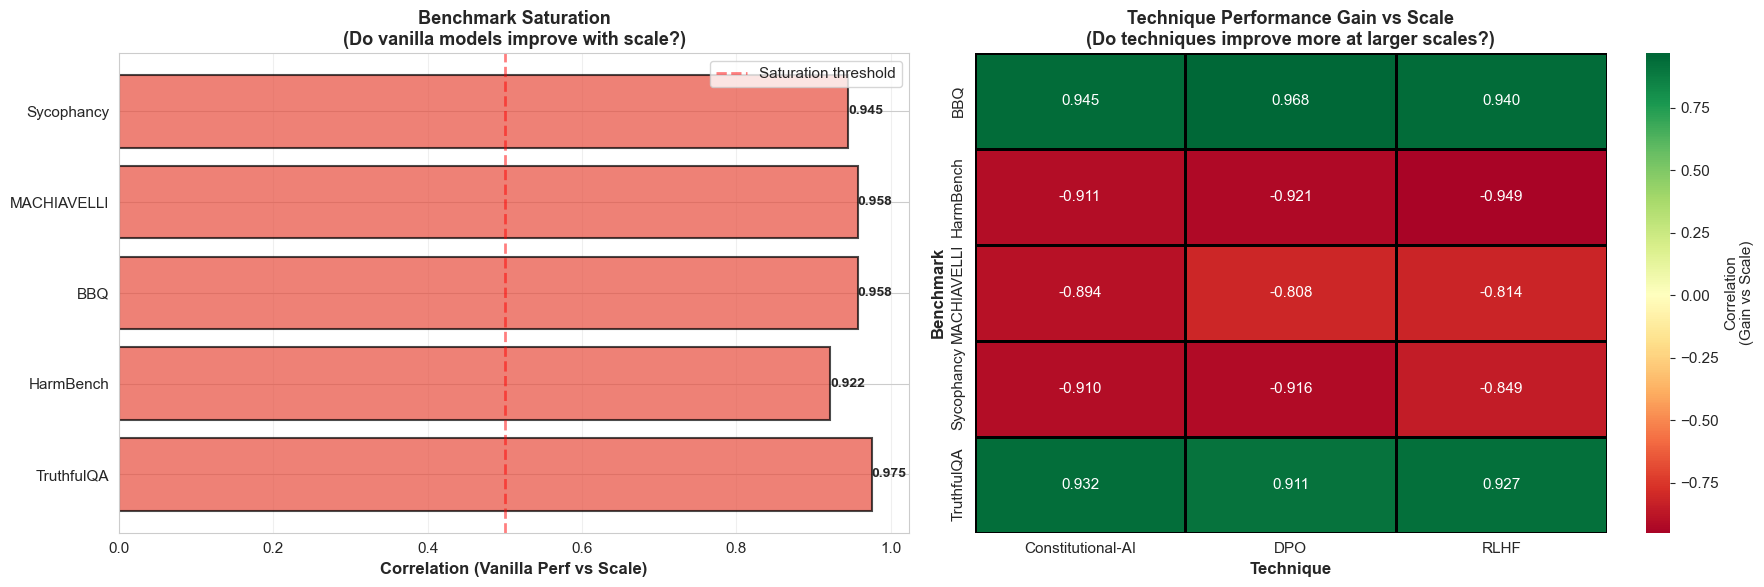


✓ Summary visualization complete


In [10]:
# Create summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Benchmark saturation
bench_colors = {'Saturated': '#E74C3C', 'Not Saturated': '#3498DB'}
saturated = bench_scaling_df[bench_scaling_df['Category'] == 'Saturated']
not_saturated = bench_scaling_df[bench_scaling_df['Category'] == 'Not Saturated']

y_pos = np.arange(len(bench_scaling_df))
colors_list = [bench_colors[cat] for cat in bench_scaling_df['Category']]

bars = ax1.barh(y_pos, bench_scaling_df['Correlation'], color=colors_list, alpha=0.7,
               edgecolor='black', linewidth=1.5)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(bench_scaling_df['Benchmark'])
ax1.set_xlabel('Correlation (Vanilla Perf vs Scale)', fontsize=12, fontweight='bold')
ax1.set_title('Benchmark Saturation\n(Do vanilla models improve with scale?)',
             fontsize=13, fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Saturation threshold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, bench_scaling_df['Correlation'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2.,
            f'{val:.3f}',
            ha='left' if val > 0 else 'right',
            va='center', fontsize=10, fontweight='bold')

# Plot 2: Technique scaling summary (heatmap)
pivot_data = tech_scaling_df.pivot(index='Benchmark', columns='Technique', values='Correlation')
sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
           cbar_kws={'label': 'Correlation\n(Gain vs Scale)'},
           linewidths=1, linecolor='black', ax=ax2)
ax2.set_title('Technique Performance Gain vs Scale\n(Do techniques improve more at larger scales?)',
             fontsize=13, fontweight='bold')
ax2.set_xlabel('Technique', fontsize=12, fontweight='bold')
ax2.set_ylabel('Benchmark', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Summary visualization complete")

## 6. Conclusions and Insights

### Key Findings

#### Benchmark Saturation
- Benchmarks where vanilla models improve with scale are **naturally solved by scaling**
- Benchmarks where vanilla models don't improve need **targeted safety interventions**

#### Technique Scaling Behavior
- **Positive slope**: Technique becomes more effective at larger scales
- **Negative slope**: Technique becomes less effective at larger scales
- **Near-zero slope**: Technique effectiveness is scale-independent

### Implications

1. **Focus research** on benchmarks that are NOT saturated by scale
2. **Prioritize techniques** where performance gain increases with scale
3. **Investigate techniques** where performance gain decreases with scale

### Limitations

- **Mockup data**: Synthetic patterns, not real measurements
- **Limited scale range**: Only 3-4 scale points per model family
- **Linear assumptions**: May miss non-linear scaling effects

### Next Steps

1. **Collect real data** from published papers
2. **Test non-linear models** for scaling relationships
3. **Add more benchmarks** for robustness
4. **Consider training compute** as additional scaling metric

---

**Methodology**: Based on SafetyWashing (NeurIPS 2024)  
**Data Source**: `../data/mockup_dataset.csv`